In [1]:
from mantid import simpleapi as msa, mtd
import numpy as np, os, math
import scipy.optimize as sopt
from matplotlib import pyplot as plt

In [161]:
%matplotlib notebook

## Load difc

In [3]:
path = '/SNS/users/lj7/reduction/SEQ/det-calibration/SEQ_d130271.h5'
msa.LoadDiffCal(
    InstrumentName='SEQ',
    Filename=path,
    WorkspaceName="SEQ_difc",
    TofMin=300, TofMax=16667)

LoadDiffCal_returns(OutputGroupingWorkspace=Title: /SNS/users/lj7/reduction/SEQ/det-calibration/SEQ_d130271.h5
Histograms: 115712
, OutputMaskWorkspace=Title: /SNS/users/lj7/reduction/SEQ/det-calibration/SEQ_d130271.h5
Histograms: 115712
Masked: 0
, OutputCalWorkspace=TableWorkspace
Columns: 6
Rows: 115712
4 MB)

In [4]:
mtd.getObjectNames()

['SEQ_difc_cal', 'SEQ_difc_group', 'SEQ_difc_mask']

In [5]:
difc_cal = mtd['SEQ_difc_cal']
difc_cal = msa.SortTableWorkspace(difc_cal, Columns='detid')

In [6]:
detID = np.array(difc_cal.column('detid'))

In [7]:
difc = np.array(difc_cal.column('difc'))

In [388]:
mask = mtd['SEQ_difc_mask']
mask = mask.extractY().flatten()

In [389]:
difc.size

115712

In [390]:
assert mask.size == difc.size

In [392]:
mask2 = np.load('./mask_diffc.npy')
mask = np.logical_or(mask, mask2)

## Load difc directly

In [130]:
difc_table = msa.Load('./difc_cal.nxs')

In [131]:
difc_table.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [132]:
difc = np.array(difc_table.column('difc'))

In [133]:
difc.size

115712

## Load L2

In [376]:
L2_calib = msa.Load('L2table.nxs')
L2_calib = msa.SortTableWorkspace(L2_calib, Columns='detid')

In [377]:
L2 = np.array(L2_calib.column('L2'))
L2.size

115712

In [229]:
L2_calib.getColumnNames()

['detid', 'L2', 'nodata']

In [230]:
nodata = np.array(L2_calib.column('nodata'), dtype=bool)

In [393]:
nodata.sum()

7647

In [394]:
mask = np.logical_or(mask, nodata)

In [395]:
mask

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [396]:
mask.sum()

11437

## Apply mask

In [234]:
difc = np.ma.masked_array(difc, mask)
L2 = np.ma.masked_array(L2, mask)

## Fit source, sample

In [21]:
import collections

In [22]:
import logging

In [23]:
logger = logging.getLogger("Align component")
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [24]:
logger.info('a')

2017-09-19 23:20:15,544 - Align component - INFO - a


In [424]:
import align

In [147]:
eulerConvention='YZX'
wks_name = "alignedWorkspace"
idf_orig = os.path.join(msa.ConfigService.getInstrumentDirectory(), 'SEQUOIA_Definition.xml')
options = collections.OrderedDict()
options['Xposition']=False
options['Yposition']=False
options['Zposition']=(-1., 1.)
options['AlphaRotation']=False
options['BetaRotation']=False
options['GammaRotation']=False

In [148]:
msa.DeleteWorkspace(wks_name)

In [149]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [150]:
source_model = instrument_model.component('source')
fit = FitSourceSample(source_model, options, difc, logger)
fit.fit()

2017-09-20 15:43:16,343 - Align component - INFO - Working on SEQUOIA/moderator. Starting position is [0.0, 0.0, -20.0114], Starting rotation is [0.0, 0.0, -0.0]
2017-09-20 15:43:17,954 - Align component - INFO - Finished optimizing SEQUOIA/moderator. Final position is [0.0, 0.0, -20.09576195388657], Final rotation is [0.0, 0.0, -0.0]


In [81]:
source_model.getParams()

[-0.0052462599375203605,
 -0.0009733221771853767,
 -19.93167908233406,
 0.0,
 0.0,
 -0.0]

In [53]:
#sample_model = instrument_model.component('sample')
#fit = FitSourceSample(sample_model, options, difc, logger)
#fit.fit()

## Fit twotheta and L2

$ DIFC = (L1+L2)/(\pi) \; sin(\theta) \times 0.0015882549421289758 \times 10^6 $

### First check the calibrated result is mostly in agreement with nominal values

In [235]:
instrument = mtd[wks_name].getInstrument()

In [236]:
print instrument.getSource().getPos()
print instrument.getSample().getPos()

[0,0,-20.0114]
[0,0,0]


In [237]:
L1 = instrument.getSample().getPos()[2]-instrument.getSource().getPos()[2]
L1

20.0114

In [238]:
L1_orig = 20.0114

L2 has to be adjusted because it was computed from V data assuming the L1 is 20.0114

In [239]:
L2_corrected = L2 + (L1_orig - L1)

In [240]:
sin_theta = difc/(0.0015882549421289758*1e6) * np.pi / (L1+L2_corrected)

In [241]:
sin_theta_pack = sin_theta[pack_model.firstIndex:pack_model.lastIndex+1].copy()

In [242]:
sin_theta_pack.shape = 8, 128

In [243]:
# sin_theta_map

<IPython.core.display.Javascript object>


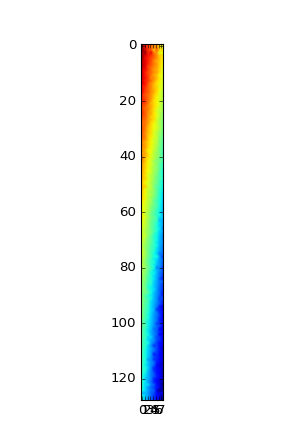

In [244]:
plt.imshow(sin_theta_pack.T)
# plt.colorbar()

In [245]:
center_sin_theta = np.average(sin_theta_pack[3:5, 60:68])

In [246]:
center_two_theta = np.arcsin(center_sin_theta)*2*180/np.pi
center_two_theta

38.951881570832697

In [247]:
L2_pack = L2[pack_model.firstIndex:pack_model.lastIndex+1]
L2_pack.shape = 8, 128

<IPython.core.display.Javascript object>


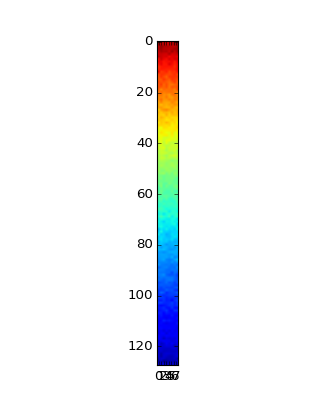

In [248]:
plt.imshow(L2_pack.T)

In [249]:
L2_center = np.average(L2_pack[3:5, 60:68])
L2_center

5.5281111001968384

nominal position

3.20998708014, -1.29480004006, 4.30555569164

In [250]:
# fix y
y_center = -1.29480004006
z_center = L2_center * np.cos(center_two_theta/180*np.pi)
x_center = (L2_center**2 - z_center**2 - y_center**2)**.5 * np.sign(3.20998708014)
print x_center, y_center, z_center

3.22513680014 -1.29480004006 4.29906941242


In [164]:
sin_theta[~sin_theta.mask][:10]

masked_array(data = [0.47593054859274114 0.4756231443994385 0.47987923558631995
 0.46481637410416105 0.47801594843167833 0.47693295523319557
 0.4782886493569799 0.47802383739567256 0.4763788048079743
 0.4774067639355043],
             mask = [False False False False False False False False False False],
       fill_value = 1e+20)

In [165]:
pp = msa.PreprocessDetectorsToMD(InputWorkspace=wks_name, OutputWorkspace='pp')
pp = msa.SortTableWorkspace(pp, Columns='DetectorID')

detid1 = np.array(pp.column('DetectorID'))
isdet = detid1>0
twotheta_nominal = np.array( pp.column('TwoTheta') )[isdet]
sin_theta_nominal = np.sin(twotheta_nominal/2.)
sin_theta_nominal = np.ma.masked_array(sin_theta_nominal, mask)

In [166]:
sin_theta_nominal[~sin_theta_nominal.mask][:10]

masked_array(data = [0.4758458573350525 0.4756890361446189 0.47553268828394524
 0.47537681734915627 0.4752214269386242 0.475066520652794
 0.47491210209400847 0.47475817486633076 0.47460474257536683
 0.4744518088280853],
             mask = [False False False False False False False False False False],
       fill_value = 1e+20)

In [184]:
tt_n_pack = twotheta_nominal[pack_model.firstIndex:pack_model.lastIndex+1].copy()
tt_n_pack.shape = 8, 128

In [189]:
tt_n_pack

array([[ 0.7286774 ,  0.7280659 ,  0.72745603, ...,  0.66983923,
         0.66955146,  0.66926717],
       [ 0.72426381,  0.72364676,  0.72303134, ...,  0.66485272,
         0.66456194,  0.66427467],
       [ 0.71985394,  0.71923131,  0.71861033, ...,  0.65986654,
         0.65957272,  0.65928246],
       ..., 
       [ 0.70664952,  0.70601004,  0.70537223, ...,  0.64491279,
         0.64460972,  0.6443103 ],
       [ 0.70225741,  0.70161227,  0.7009688 , ...,  0.63993073,
         0.63962452,  0.63932201],
       [ 0.69787046,  0.69721964,  0.6965705 , ...,  0.63495039,
         0.63464103,  0.63433539]])

### Now fit

In [308]:
options = collections.OrderedDict()
options['Xposition']=(-.2, .2)
options['Yposition']=False
options['Zposition']=(-.2, .2)
options['AlphaRotation']=False
options['BetaRotation']=False
options['GammaRotation']=False

In [309]:
print options

OrderedDict([('Xposition', (-0.2, 0.2)), ('Yposition', False), ('Zposition', (-0.2, 0.2)), ('AlphaRotation', False), ('BetaRotation', False), ('GammaRotation', False)])


In [310]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [311]:
pack_model = instrument_model.component('B10/eightpack', type='detpack')

In [312]:
pack_model.getParams()

[3.20998708014, -1.29480004006, 4.30555569164, -143.29380037000004, 0.0, -0.0]

In [313]:
fit = FitPackDifc(pack_model, options, difc, logger)

fit.fit()

2017-09-21 10:12:34,661 - Align component - INFO - Working on SEQUOIA/B row/B10/eightpack. Starting position is [3.20998708014, -1.29480004006, 4.30555569164], Starting rotation is [-143.29380037000004, 0.0, -0.0]
2017-09-21 10:12:43,582 - Align component - INFO - Finished optimizing SEQUOIA/B row/B10/eightpack. Final position is [3.100482795870287, -1.29480004006, 4.10555569164], Final rotation is [-143.29380037000004, 0.0, -0.0]


In [314]:
pack_model.getParams()

[3.100482795870287,
 -1.29480004006,
 4.10555569164,
 -143.29380037000004,
 0.0,
 -0.0]

In [409]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [410]:
pack_model = instrument_model.component('B10/eightpack', type='detpack')

In [411]:
pack_model.getParams()

[3.20998708014, -1.29480004006, 4.30555569164, -143.29380037000004, 0.0, -0.0]

In [412]:
saved_difc = pack_model.difc()
saved_twotheta, saved_L2 = pack_model.twotheta_and_L2()

(115712,) (115712,)


In [413]:
options = collections.OrderedDict()
options['Xposition']=(-.2, .2)
options['Yposition']=False
options['Zposition']=(-.2, .2)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit = FitPackTwothetaAndL2(pack_model, options, sin_theta, L2, logger)
fit.fit()

2017-09-21 14:26:03,519 - Align component - INFO - Working on SEQUOIA/B row/B10/eightpack. Starting position is [3.20998708014, -1.29480004006, 4.30555569164], Starting rotation is [-143.29380037000004, 0.0, -0.0]


(115712,) (115712,)
0.00102940117986
(115712,) (115712,)
0.00155614788495
(115712,) (115712,)
7.02227094829e-05
(115712,) (115712,)
0.000800530389109
(115712,) (115712,)
0.000113458271303
(115712,) (115712,)
0.00067617826298
(115712,) (115712,)
0.00310687951869
(115712,) (115712,)
0.00104482836996
(115712,) (115712,)
0.00260992619836
(115712,) (115712,)
0.002648765231
(115712,) (115712,)
0.00161640296513
(115712,) (115712,)
0.000731359851327
(115712,) (115712,)
0.00211187422032
(115712,) (115712,)
0.00166961526917
(115712,) (115712,)
0.00127472429803
(115712,) (115712,)
0.00184701994067
(115712,) (115712,)
0.000541204484154
(115712,) (115712,)
0.0025444164481
(115712,) (115712,)
1.57270651502e-05
(115712,) (115712,)
0.000157033569957
(115712,) (115712,)
0.00463437443271
(115712,) (115712,)
0.00118364525302
(115712,) (115712,)
0.000269191232543
(115712,) (115712,)
0.00121891052654
(115712,) (115712,)
0.00193080899793
(115712,) (115712,)
0.00179165744343
(115712,) (115712,)
0.00034935602

(115712,) (115712,)
0.000126691895506
(115712,) (115712,)
0.000128609507208
(115712,) (115712,)
6.45251410185e-05
(115712,) (115712,)
1.49627901841e-05
(115712,) (115712,)
0.000139926486877
(115712,) (115712,)
0.00016574842774
(115712,) (115712,)
0.000119886968926
(115712,) (115712,)
0.000133035091589
(115712,) (115712,)
5.59002023116e-05
(115712,) (115712,)
7.14568436108e-05
(115712,) (115712,)
8.61187280195e-05
(115712,) (115712,)
4.82836476666e-05
(115712,) (115712,)
0.000105822896318
(115712,) (115712,)
0.00010976359034
(115712,) (115712,)
1.78231967259e-05
(115712,) (115712,)
0.00011099504801
(115712,) (115712,)
2.69845386918e-05
(115712,) (115712,)
0.000129465535631
(115712,) (115712,)
2.53448134384e-05
(115712,) (115712,)
7.47036484283e-05
(115712,) (115712,)
3.06356433004e-05
(115712,) (115712,)
7.85273938518e-05
(115712,) (115712,)
1.73604079352e-05
(115712,) (115712,)
4.59411231123e-05
(115712,) (115712,)
1.82597965713e-05
(115712,) (115712,)
1.65847591994e-05
(115712,) (1157

(115712,) (115712,)
1.42610524174e-05
(115712,) (115712,)
1.43020855947e-05
(115712,) (115712,)
1.44483890209e-05
(115712,) (115712,)
1.42884357343e-05
(115712,) (115712,)
1.4468293702e-05
(115712,) (115712,)
1.43059915114e-05
(115712,) (115712,)
1.51922994667e-05
(115712,) (115712,)
1.44713999825e-05
(115712,) (115712,)
1.50451480001e-05
(115712,) (115712,)
1.4422352037e-05
(115712,) (115712,)
1.89837310646e-05
(115712,) (115712,)
1.43255958332e-05
(115712,) (115712,)
1.44658553361e-05
(115712,) (115712,)
1.42373879433e-05
(115712,) (115712,)
1.45164173157e-05
(115712,) (115712,)
1.46182206197e-05
(115712,) (115712,)
1.6858381642e-05
(115712,) (115712,)
1.55428920733e-05
(115712,) (115712,)
1.45483067629e-05
(115712,) (115712,)
1.56456918701e-05
(115712,) (115712,)
1.55258180619e-05
(115712,) (115712,)
1.61329013404e-05
(115712,) (115712,)
1.42287520796e-05
(115712,) (115712,)
1.45390510933e-05
(115712,) (115712,)
1.47504403495e-05
(115712,) (115712,)
1.44352698341e-05
(115712,) (1157

2017-09-21 14:27:51,317 - Align component - INFO - Finished optimizing SEQUOIA/B row/B10/eightpack. Final position is [3.223119944965284, -1.29480004006, 4.299457184295583], Final rotation is [-143.09187460118517, 0.0, 0.0]


(115712,) (115712,)
1.42178677389e-05


In [328]:
pack_model.getParams()

[3.223249036925353,
 -1.29480004006,
 4.299520305209903,
 -143.29379934038187,
 0.0,
 0.0]

In [330]:
"""
options = collections.OrderedDict()
options['Xposition']=False
options['Yposition']=False
options['Zposition']=False
options['AlphaRotation']= (-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit = FitPackTwothetaAndL2(pack_model, options, sin_theta, L2, logger)
fit.fit()
"""

"\noptions = collections.OrderedDict()\noptions['Xposition']=False\noptions['Yposition']=False\noptions['Zposition']=False\noptions['AlphaRotation']= (-5., 5.)\noptions['BetaRotation']=False\noptions['GammaRotation']=False \n\nfit = FitPackTwothetaAndL2(pack_model, options, sin_theta, L2, logger)\nfit.fit()\n"

In [331]:
# pack_model.getParams()

<IPython.core.display.Javascript object>


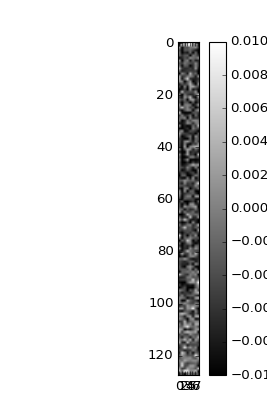

In [332]:
old_diff_L2 = saved_L2- fit.L2
old_diff_L2.shape = 8,128

plt.imshow(old_diff_L2.T, cmap='gray')
plt.clim(-.01, .01)
plt.colorbar()

In [333]:
new_twotheta, new_L2 = pack_model.twotheta_and_L2()

(115712,) (115712,)


<IPython.core.display.Javascript object>


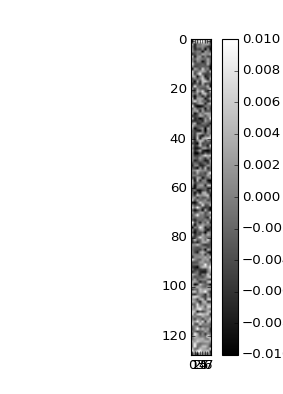

In [335]:
new_diff_L2 = new_L2 - fit.L2
new_diff_L2.shape = 8,128

plt.imshow(new_diff_L2.T, cmap='gray')
plt.clim(-.01, .01)
plt.colorbar()

In [336]:
target_L2 = fit.L2.copy()
new_L2.shape = saved_L2.shape = target_L2.shape = 8, 128

In [337]:
print target_L2[:, 0]
print new_L2[:, 0]
print saved_L2[:, 0]

[5.702991962432861 5.692929744720459 5.695333957672119 5.693321228027344
 5.682201862335205 5.695701599121094 5.684253215789795 5.697860240936279]
[5.6973403680078905 5.696875541969483 5.696542779765271 5.696342104539513
 5.696273530252162 5.696337061674039 5.696532694385155 5.696860414776265]
[5.694169876897138 5.693773397242648 5.693509062132193 5.693376889971604
 5.693376889965396 5.693509062113573 5.693773397211615 5.694169876853694]


In [338]:
new_difc = pack_model.difc()

In [339]:
new_difc

masked_array(data = [4644.7481894628545 4640.496869090217 4636.258351829861 4632.032728549799
 4627.8200903021425 4623.620528319041 4619.434134008539 4615.260998950409
 4611.1012148919035 4606.954873743446 4602.822067574278 4598.702888608028
 4594.597429218226 4590.505781923781 4586.428039384348 4582.364294395692
 4578.314639884954 4574.279168905869 4570.257974633923 4566.251150361461
 4562.25878949271 4558.280985538764 4554.317832112511 4550.3694229234725
 4546.435851772625 4542.517212547118 4538.61359921498 4534.72510581971
 4530.851826474868 4526.993855358554 4523.15128670788 4519.324214813326
 4515.512734013092 4511.716938687361 4507.936923252502 4504.172782155244
 4500.424609866756 4496.692500876699 4492.976549687203 4489.2768508068075
 4485.593498744314 4481.926588002621 4478.276213072482 4474.642468426208
 4471.025448511319 4467.425247744148 4463.84196050339 4460.275681123581
 4456.726503888561 4453.194523024835 4153.95808819156 4150.795454093737
 4147.653883693715 4144.53347615

In [343]:
difc[pack_model.firstIndex:pack_model.lastIndex+1]

masked_array(data = [4630.7508272614605 4626.479097626123 4673.750546647079 4636.657134651279
 4647.364343887482 4650.327650135007 4627.79980744915 4637.408652784933
 4630.646677313671 4618.867703616305 4611.627283120674 4615.199668759364
 4619.980561944014 4609.6071829895445 4606.7003770876345 4592.185043435606
 4602.572184454658 4600.912023556395 4575.646800949871 4583.6664772713875
 4581.54610873423 4573.991752131335 4557.118336589443 4554.82624593666
 4564.006914973161 4563.42240221514 4548.797414177465 4537.087479820115
 4535.643838540221 4530.445985096891 4537.63747601896 4535.853545381509
 4530.089584748058 4531.010657142319 4517.990414474654 4502.174063213131
 4511.397271384752 4495.778979914601 4503.208414549756 4486.08833445245
 4498.773790185919 4509.260729478743 4493.718973022686 4482.78955280454
 4476.665582284065 4478.166380381782 4468.298304581842 4468.264883467985
 4466.109561206104 4455.177471620582 4145.433679108986 4141.5613894571015
 4116.266919905314 4136.129703212

## D23

In [414]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [415]:
d23_model = instrument_model.component('D23/eightpack', type='detpack')

In [416]:
d23_model.getParams()

[0.565047087836, 1.22910000001, 5.3415347703, -173.96150000000003, 0.0, -0.0]

In [417]:
d23_saved_difc = d23_model.difc()
d23_saved_twotheta, d23_saved_L2 = d23_model.twotheta_and_L2()

(115712,) (115712,)


In [418]:
options = collections.OrderedDict()
options['Xposition']=(-.3, .3)
options['Yposition']=False
options['Zposition']=(-.3, .3)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit_d23 = FitPackTwothetaAndL2(d23_model, options, sin_theta, L2, logger)
fit_d23.fit()

2017-09-21 14:29:48,547 - Align component - INFO - Working on SEQUOIA/D row/D23/eightpack. Starting position is [0.565047087836, 1.22910000001, 5.3415347703], Starting rotation is [-173.96150000000003, 0.0, -0.0]


(115712,) (115712,)
0.00558912268645
(115712,) (115712,)
0.0111842423958
(115712,) (115712,)
0.0111628240653
(115712,) (115712,)
0.00631416080266
(115712,) (115712,)
0.00549563289831
(115712,) (115712,)
0.00461715972203
(115712,) (115712,)
0.00246940582338
(115712,) (115712,)
0.00207592549734
(115712,) (115712,)
0.00239673665667
(115712,) (115712,)
0.00581748786741
(115712,) (115712,)
0.0314481942884
(115712,) (115712,)
0.00294391741649
(115712,) (115712,)
0.00216507733821
(115712,) (115712,)
0.0101361764882
(115712,) (115712,)
0.018565287445
(115712,) (115712,)
0.00629515337865
(115712,) (115712,)
0.00534947998506
(115712,) (115712,)
0.00349829305764
(115712,) (115712,)
0.00567310427945
(115712,) (115712,)
0.00918830599265
(115712,) (115712,)
0.0261267361433
(115712,) (115712,)
0.00303015424235
(115712,) (115712,)
0.00500974321255
(115712,) (115712,)
0.00368252227985
(115712,) (115712,)
0.00490877496569
(115712,) (115712,)
0.00446817742222
(115712,) (115712,)
0.00347022786283
(115712,

(115712,) (115712,)
0.00358398654771
(115712,) (115712,)
0.00274196309791
(115712,) (115712,)
0.0023675182425
(115712,) (115712,)
0.00151160128076
(115712,) (115712,)
0.00277392266407
(115712,) (115712,)
0.00130857781434
(115712,) (115712,)
0.00106277413291
(115712,) (115712,)
0.00193779736305
(115712,) (115712,)
0.00111109091682
(115712,) (115712,)
0.00153737209156
(115712,) (115712,)
0.0017405084598
(115712,) (115712,)
0.00169825009884
(115712,) (115712,)
0.00142626093741
(115712,) (115712,)
0.00140396629328
(115712,) (115712,)
0.00156467593293
(115712,) (115712,)
0.00109494026838
(115712,) (115712,)
0.0010104411659
(115712,) (115712,)
0.00136288569995
(115712,) (115712,)
0.00216104810697
(115712,) (115712,)
0.00118511874291
(115712,) (115712,)
0.0010733408982
(115712,) (115712,)
0.00213543179489
(115712,) (115712,)
0.00174757930889
(115712,) (115712,)
0.00115208202684
(115712,) (115712,)
0.00111957198504
(115712,) (115712,)
0.0010273541443
(115712,) (115712,)
0.00133398058369
(11571

(115712,) (115712,)
0.00101202084405
(115712,) (115712,)
0.00101309376657
(115712,) (115712,)
0.00100966480671
(115712,) (115712,)
0.00100376731857
(115712,) (115712,)
0.00114655998435
(115712,) (115712,)
0.00104846004424
(115712,) (115712,)
0.00100943269376
(115712,) (115712,)
0.00113880628031
(115712,) (115712,)
0.00103803050962
(115712,) (115712,)
0.00109246336995
(115712,) (115712,)
0.00113645241489
(115712,) (115712,)
0.00103952908652
(115712,) (115712,)
0.00100510482713
(115712,) (115712,)
0.0010108264348
(115712,) (115712,)
0.00114211454602
(115712,) (115712,)
0.00104609148356
(115712,) (115712,)
0.00103056558748
(115712,) (115712,)
0.00105944164655
(115712,) (115712,)
0.00101721683228
(115712,) (115712,)
0.00109463242942
(115712,) (115712,)
0.00100599626297
(115712,) (115712,)
0.00100455417696
(115712,) (115712,)
0.00100812086841
(115712,) (115712,)
0.00100749074265
(115712,) (115712,)
0.0010165798014
(115712,) (115712,)
0.00107916204511
(115712,) (115712,)
0.00100952736421
(11

2017-09-21 14:31:55,941 - Align component - INFO - Finished optimizing SEQUOIA/D row/D23/eightpack. Final position is [0.5297698363835667, 1.22910000001, 5.318474315028467], Final rotation is [-178.36422612831365, 0.0, 0.0]


(115712,) (115712,)
0.00100337554373


In [419]:
d23_model.getParams()

[0.5297698363835667,
 1.22910000001,
 5.318474315028467,
 -178.36422612831365,
 0.0,
 0.0]

<IPython.core.display.Javascript object>


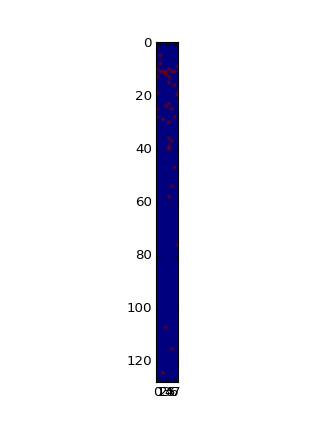

In [404]:
d23_mask = d23_model.mask.copy()
d23_mask.shape = 8, -1
plt.imshow(d23_mask.T)

<IPython.core.display.Javascript object>


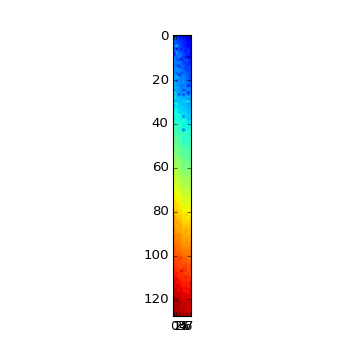

In [365]:
d23_sin_theta = sin_theta[d23_model.firstIndex: d23_model.lastIndex+1].copy()
# print d23_sin_theta.shape
d23_sin_theta.shape = 8, 128
plt.imshow(d23_sin_theta.T)

In [387]:
d23_model.firstIndex, d23_model.lastIndex

(100352, 101375)

In [366]:
d23_center_sin_theta = np.average(d23_sin_theta[3:5, 62:66])
print d23_center_sin_theta

0.12253042552


In [372]:
d23_center_twotheta = np.arcsin(d23_center_sin_theta)*2

In [379]:
d23_L2 = L2[d23_model.firstIndex:d23_model.lastIndex+1].copy()
print d23_L2.shape
d23_L2.shape = 8, 128
d23_center_L2 = np.average(d23_L2[3:5, 62::66])
print d23_center_L2

(1024,)
5.49990344048


In [380]:
y_center = 1.22910000001
z_center = d23_center_L2 * np.cos(d23_center_twotheta)
x_center = (d23_center_L2**2 - z_center**2 - y_center**2)**.5 * np.sign(0.565047087836)
print x_center, y_center, z_center

0.527857854661 1.22910000001 5.33475558295


In [382]:
fit_d23.cost((0.527857854661, 5.33475558295, -178.19560855381187))

(115712,) (115712,)
0.0011555486346


0.0011555486345982105

In [405]:
new_tt, new_L2 = d23_model.twotheta_and_L2()

(115712,) (115712,)


In [406]:
np.sin(new_tt/2.)

masked_array(data = [0.08298431839668743 0.08359592300754319 0.08421158491387921
 0.08483119955896995 0.08545466465608112 0.08608188015432032
 0.08671274820329544 0.0873471731167664 0.08798506133545653
 0.08862632138917213 -- 0.08991860133539546 0.0905694483852057 --
 0.09188013909081005 0.09253982138602539 0.09320229045421322
 0.0938674701339496 0.09453528600114543 -- 0.09587853705711015
 0.09655383173895461 0.0972314815191984 0.09791142008944792
 0.09859358265332917 -- 0.09996432792213025 0.1006527882747115 --
 0.10203558887826844 0.10272981491073023 0.10342585076227505
 0.10412364249249308 0.10482313737229666 0.10552428385370997
 0.10622703154031407 0.106931331158356 0.10763713452850128
 0.10834439453824837 0.10905306511498462 0.10976310119968306
 0.11047445872123257 0.11118709457139685 0.11190096658039204
 0.11261603349306824 0.11333225494569767 0.1140495914433522
 0.11476800433785563 0.11548745580631235 0.11620790883019066
 0.1309166215492371 0.13169151837373827 0.1324661591630994

In [407]:
fit_d23.sin_theta

masked_array(data = [0.08495134844680403 0.08549559146219335 0.08610198370459295
 0.08669447442876008 0.08614319282759095 0.08743742786009982
 0.08853526150317421 0.08915853616465744 0.07599413151762867
 0.07547595139461688 0.09231004261422088 0.09161150499845709
 0.09228333194387439 0.0893948457488309 0.08962835350680491
 0.09177851176434196 0.09031098436190724 0.09115893459036598
 0.09299391389907509 0.093548874417794 0.09750334807239448
 0.09613920210326032 0.09626526579756521 0.09643173990601427
 0.0973847749654481 0.09024867275447239 0.10827504601131674
 0.09669437695449788 0.10859498450877615 0.09911230417155721
 0.09703749373709371 0.1026165266501574 0.09678189802798728
 0.1036065245055841 0.10448963102769228 0.10539364943036289
 0.10711727255395126 0.10395282060623855 0.10190732857240184
 0.10826335063059117 0.10860309996719625 0.11075970691370142
 0.11144084189213939 0.11071782852279922 0.11271299536717036
 0.11345785005643999 0.11426491009813462 0.11435385406928382
 0.1184047

## C21

In [420]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [421]:
c21_model = instrument_model.component('C21/eightpack', type='detpack')
print c21_model.getParams()

[0.955168885442, -0.0389000000002, 5.42691364704, -170.01784216, 0.0, -0.0]


In [422]:
options = collections.OrderedDict()
options['Xposition']=(-.3, .3)
options['Yposition']=False
options['Zposition']=(-.3, .3)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit_c21 = FitPackTwothetaAndL2(c21_model, options, sin_theta, L2, logger)
fit_c21.fit()

2017-09-21 14:42:33,064 - Align component - INFO - Working on SEQUOIA/C row/C21/eightpack. Starting position is [0.955168885442, -0.0389000000002, 5.42691364704], Starting rotation is [-170.01784216, 0.0, -0.0]


(115712,) (115712,)
0.0105621582304
(115712,) (115712,)
0.0406393437942
(115712,) (115712,)
0.00954799880306
(115712,) (115712,)
0.000668830820624
(115712,) (115712,)
0.000258399378057
(115712,) (115712,)
0.0103614984705
(115712,) (115712,)
0.00122766400945
(115712,) (115712,)
0.0660405550831
(115712,) (115712,)
0.0620241233549
(115712,) (115712,)
0.0279899670816
(115712,) (115712,)
0.0042431279307
(115712,) (115712,)
0.0312120877624
(115712,) (115712,)
0.016864233117
(115712,) (115712,)
0.0531191322344
(115712,) (115712,)
0.0654750817156
(115712,) (115712,)
0.0492196333774
(115712,) (115712,)
0.0365451656264
(115712,) (115712,)
0.0246852806601
(115712,) (115712,)
0.0591508876015
(115712,) (115712,)
0.00888885288263
(115712,) (115712,)
0.00167666329114
(115712,) (115712,)
0.00528016405518
(115712,) (115712,)
0.00189245980384
(115712,) (115712,)
0.0415857696727
(115712,) (115712,)
0.00979647410164
(115712,) (115712,)
0.0370189143332
(115712,) (115712,)
0.00579355564132
(115712,) (115712

(115712,) (115712,)
0.000401005246277
(115712,) (115712,)
0.0102600133758
(115712,) (115712,)
0.00104535028853
(115712,) (115712,)
0.000667426429679
(115712,) (115712,)
0.00475096491027
(115712,) (115712,)
0.000283523575728
(115712,) (115712,)
0.000210461519914
(115712,) (115712,)
0.00519064962106
(115712,) (115712,)
0.000748384630877
(115712,) (115712,)
0.00297620303366
(115712,) (115712,)
0.000846340678912
(115712,) (115712,)
0.000864780002453
(115712,) (115712,)
0.0182966734192
(115712,) (115712,)
0.000643052519093
(115712,) (115712,)
0.000853487428856
(115712,) (115712,)
0.00112887351523
(115712,) (115712,)
0.00588989757333
(115712,) (115712,)
0.00802830087183
(115712,) (115712,)
0.000177696024046
(115712,) (115712,)
0.000594708816542
(115712,) (115712,)
0.000348613499114
(115712,) (115712,)
0.0014722173391
(115712,) (115712,)
0.00054535921556
(115712,) (115712,)
0.00289326263287
(115712,) (115712,)
0.0014033252314
(115712,) (115712,)
0.00058829615907
(115712,) (115712,)
0.00129475

(115712,) (115712,)
0.000330677762139
(115712,) (115712,)
0.000250910390024
(115712,) (115712,)
0.000221248926122
(115712,) (115712,)
0.000466575860358
(115712,) (115712,)
0.000712608279394
(115712,) (115712,)
0.000238552388632
(115712,) (115712,)
0.000285331246809
(115712,) (115712,)
0.000261330575252
(115712,) (115712,)
0.0004349798847
(115712,) (115712,)
0.000284310965209
(115712,) (115712,)
0.000274509719116
(115712,) (115712,)
0.000208959184413
(115712,) (115712,)
0.000251107928008
(115712,) (115712,)
0.000316701937307
(115712,) (115712,)
0.000689034490252
(115712,) (115712,)
0.000258789731941
(115712,) (115712,)
0.000260491945062
(115712,) (115712,)
0.000243997185521
(115712,) (115712,)
0.000202610319508
(115712,) (115712,)
0.000365375352113
(115712,) (115712,)
0.000640177269346
(115712,) (115712,)
0.000391805702731
(115712,) (115712,)
0.000342082010319
(115712,) (115712,)
0.000410952295304
(115712,) (115712,)
0.000385234435608
(115712,) (115712,)
0.000391344678326
(115712,) (115

(115712,) (115712,)
0.000211622523083
(115712,) (115712,)
0.000180443235045
(115712,) (115712,)
0.000179458194974
(115712,) (115712,)
0.000184052941173
(115712,) (115712,)
0.000178259802507
(115712,) (115712,)
0.000185628043682
(115712,) (115712,)
0.000177307116047
(115712,) (115712,)
0.00017709501336
(115712,) (115712,)
0.000177079157909
(115712,) (115712,)
0.000179925768065
(115712,) (115712,)
0.000178051117508
(115712,) (115712,)
0.000179245553749
(115712,) (115712,)
0.000224986771577
(115712,) (115712,)
0.000186935171583
(115712,) (115712,)
0.000177209212298
(115712,) (115712,)
0.000185033138454
(115712,) (115712,)
0.000177556325233
(115712,) (115712,)
0.00017963608324
(115712,) (115712,)
0.000193260914993
(115712,) (115712,)
0.000191638307757
(115712,) (115712,)
0.000177851023595
(115712,) (115712,)
0.000177440547017
(115712,) (115712,)
0.000182379806075
(115712,) (115712,)
0.000201575748151
(115712,) (115712,)
0.000179972885963
(115712,) (115712,)
0.000177427955074
(115712,) (115

2017-09-21 14:45:20,347 - Align component - INFO - Finished optimizing SEQUOIA/C row/C21/eightpack. Final position is [0.9667016872688518, -0.0389000000002, 5.423302902045731], Final rotation is [-170.76307593596368, 0.0, 0.0]


(115712,) (115712,)
0.000176884702042


In [423]:
print c21_model.getParams()

[0.9667016872688518, -0.0389000000002, 5.423302902045731, -170.76307593596368, 0.0, 0.0]
